# Optimizing stixel size

Yangkang Chen<br>
Jan 12, 2023

This notebook is to explore why and how we should tune the gridding hyperparameters of the Quadtree algorithm.

## Why should we even care about the grid size parameter?

As mentioned in [the brief introduction to `stemflow`](https://chenyangkang.github.io/stemflow/A_brief_introduction/A_brief_introduction.html), the main target of `AdaSTEM` modeling framework is to solve the long-distance/long-range prediction problem.

This is realized by gridding data into smaller spatial and temporal grids (that is what `temporal sliding window` and spatial `Quadtree algorithm` are doing), so that each prediction will only rely on the trained adjacency information in space and time.

It is similar to the concept of `spatial regression` or `spatial/temporal lag`, only that in our cases the lag is a sharp truncation (but after averaging across ensembles, the edge will be soften).

Using two extreme examples we can tell the necessity of set good gridding parameters:
- Extremely large: Imagine if you set extremely large sliding window interval and grid size for Quadtree algo – there will be only one stixel. That is, it's equivalent to bulk regression without partitioning. Apparently this is not what we want.
- Extremely small: Imagine the grids are extremely small that each grid only contain one sample – That will be an 100% overfitting.

Therefore, we need to assess which parameter setting is best for our modeling goal: to 

- 1. improve the model performance
- 2. avoid overfitting 
- 3. reach a balance between accuracy and efficienty





In [2]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas
import time

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle

# warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


In [5]:
data.head()

,longitude,latitude,count,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,0.0,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,9.0,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,0.0,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,0.0,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,2.0,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


## Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values

## First thing first: Spatiotemporal train-test-split

In [6]:
from stemflow.model_selection import ST_CV
CV = 5

Since `ST_CV` function returns a one-off generator, we will call it in the later loop. Here we define the parameters for fold (`CV=5`).

## Train AdaSTEMRegressor with hurdle model as base model

`stemflow` have 4 important gridding parameters. Actually only two:

The maximum grid length, and the minimum grid length. It can be separately set by longitude and latitude, and that will be 4.

Now we set the gradient that we want to explore: `5, 10, 25, 50, and 100` degree units.


In [64]:
min_grid_list = [5, 10, 25, 50, 100]
max_grid_list = [5, 10, 25, 50, 100]
min_grids, max_grids = np.meshgrid(min_grid_list, max_grid_list)
min_grids_pr = min_grids.flatten()
max_grids_pr = max_grids.flatten()

In [70]:
meshed = np.array([[a,b] for a,b in zip(min_grids_pr, max_grids_pr) if not a>b])
min_grids = list(meshed[:,0])
max_grids = list(meshed[:,1])

We define a function that takes our input gridding parameters and return a AdaSTEM model:

In [34]:
def make_model(min_grid, max_grid):
    model = AdaSTEMRegressor(
        base_model=Hurdle(
            classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
            regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
        ),
        save_gridding_plot = True,
        ensemble_fold=10, 
        min_ensemble_required=7,
        grid_len_lon_upper_threshold=max_grid,
        grid_len_lon_lower_threshold=min_grid,
        grid_len_lat_upper_threshold=max_grid,
        grid_len_lat_lower_threshold=min_grid,
        points_lower_threshold=50,
        Spatio1='longitude',
        Spatio2 = 'latitude', 
        Temporal1 = 'DOY',
        use_temporal_to_train=True,
        njobs=4                  
    )
    return model




## Parameter GridSearch

We start training each set of parameters with CV. That's right, it's grid search CV.

We then evaluate each pair of them.

In [ ]:
metrics_list = []

for min_grid, max_grid in tqdm(zip(min_grids, max_grids), total=len(min_grids)):
    if min_grid>max_grid:
        continue
    
    if os.path.exists(f'./grid_size_CV_{min_grid}_{max_grid}.csv'):
        one_set_list = pd.read_csv(f'./grid_size_CV_{min_grid}_{max_grid}.csv')
        metrics_list.append(one_set_list)
        continue
    
    one_set_list = []
    for cv_index, (X_train, X_test, y_train, y_test) in enumerate(ST_CV(X, y, 
                                                                Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                                random_state=42, CV=5)):

        print(f'Training CV {cv_index}, ',min_grid, max_grid)
        
        model = make_model(min_grid, max_grid)
        
        start_t = time.time()
        model.fit(X_train.reset_index(drop=True), y_train)
        end_t = time.time()
        training_time = end_t - start_t
        
        start_t = time.time()
        pred = model.predict(X_test, verbosity=0)
        end_t = time.time()
        prediction_time = end_t - start_t
        
        perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
        
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
        }).dropna()
        eval_metrics = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)
        
        eval_metrics['min_grid'] = min_grid
        eval_metrics['max_grid'] = max_grid
        eval_metrics['perc_unpredictable'] = perc
        eval_metrics['training_time'] = training_time
        eval_metrics['prediction_time'] = prediction_time
        eval_metrics['CV'] = cv_index
        
        print(eval_metrics)
        one_set_list.append(eval_metrics)
    
    one_set_list = pd.DataFrame(one_set_list)
    one_set_list.to_csv(f'./grid_size_CV_{min_grid}_{max_grid}.csv', index=False)
    metrics_list.append(one_set_list)
    
    

Save the metrics and average across CV:

In [39]:
metrics_df = pd.concat(metrics_list, axis=0).reset_index(drop=False)
metrics_df.to_csv(f'./grid_size_CV_all.csv', index=False)
mean_metrics_df = metrics_df.groupby(['min_grid','max_grid']).mean().reset_index()


In [24]:
mean_metrics_df

,min_grid,max_grid,index,AUC,kappa,f1,precision,recall,average_precision,Spearman_r,Pearson_r,R2,MAE,MSE,poisson_deviance_explained,perc_unpredictable,training_time,prediction_time,CV,min_max
0,5,5,2.0,0.766567,0.386356,0.529631,0.399499,0.785547,0.351599,0.475464,0.176335,-0.088440,4.313501,3201.812311,0.168986,0.069968,550.624023,34.156900,2.0,5_5
1,5,10,2.0,0.766293,0.384342,0.528116,0.397392,0.787022,0.350202,0.474791,0.183958,-0.082211,4.323978,3180.035715,0.177810,0.066435,549.099831,33.059364,2.0,5_10
2,5,25,2.0,0.767678,0.385671,0.526272,0.396029,0.784189,0.347749,0.474858,0.179520,-0.090784,4.330542,3199.886902,0.166251,0.032443,525.380245,35.030489,2.0,5_25
3,5,50,2.0,0.769342,0.387989,0.527998,0.397298,0.786886,0.349333,0.476960,0.176917,-0.103958,4.310125,3215.157929,0.154506,0.033007,543.400516,47.125380,2.0,5_50
4,5,100,2.0,0.768950,0.387201,0.527325,0.396661,0.786361,0.348692,0.475990,0.177920,-0.181310,4.322645,3265.734992,0.156523,0.032102,550.507193,37.970373,2.0,5_100
5,10,10,2.0,0.770207,0.401170,0.534963,0.410151,0.769005,0.355001,0.480092,0.178716,-0.061535,4.220438,3145.431430,0.151950,0.024184,416.977622,22.460894,2.0,10_10
6,10,25,2.0,0.771196,0.401325,0.534598,0.409138,0.771064,0.354489,0.481477,0.183953,-0.053745,4.181458,3108.307795,0.180126,0.015502,420.385201,23.117145,2.0,10_25
7,10,50,2.0,0.771446,0.401462,0.534607,0.409021,0.771517,0.354472,0.481751,0.185360,-0.045559,4.206646,3100.277624,0.166049,0.012245,427.113656,23.544816,2.0,10_50
8,10,100,2.0,0.771775,0.402631,0.535332,0.410015,0.771005,0.355098,0.482410,0.189427,-0.033620,4.183551,3095.337014,0.172070,0.011901,420.840633,25.075172,2.0,10_100
9,25,25,2.0,0.767676,0.413165,0.539287,0.424404,0.739507,0.357922,0.478710,0.192752,-0.014192,4.057915,3040.694687,0.154268,0.000930,235.331810,12.127943,2.0,25_25


## Plot results

Now we plot these metrics and see which parameter set could be optimum.

Define a helper function for arranging the subplots:

In [97]:
def find_the_best_gridding(len_fig, column=None):
    
    if column is None:
        for i in range(1000):
            if i**2<len_fig:
                continue
            else:
                return i
        
    else:
        for i in range(1000):
            if i*column<len_fig:
                continue
            else:
                return i
            

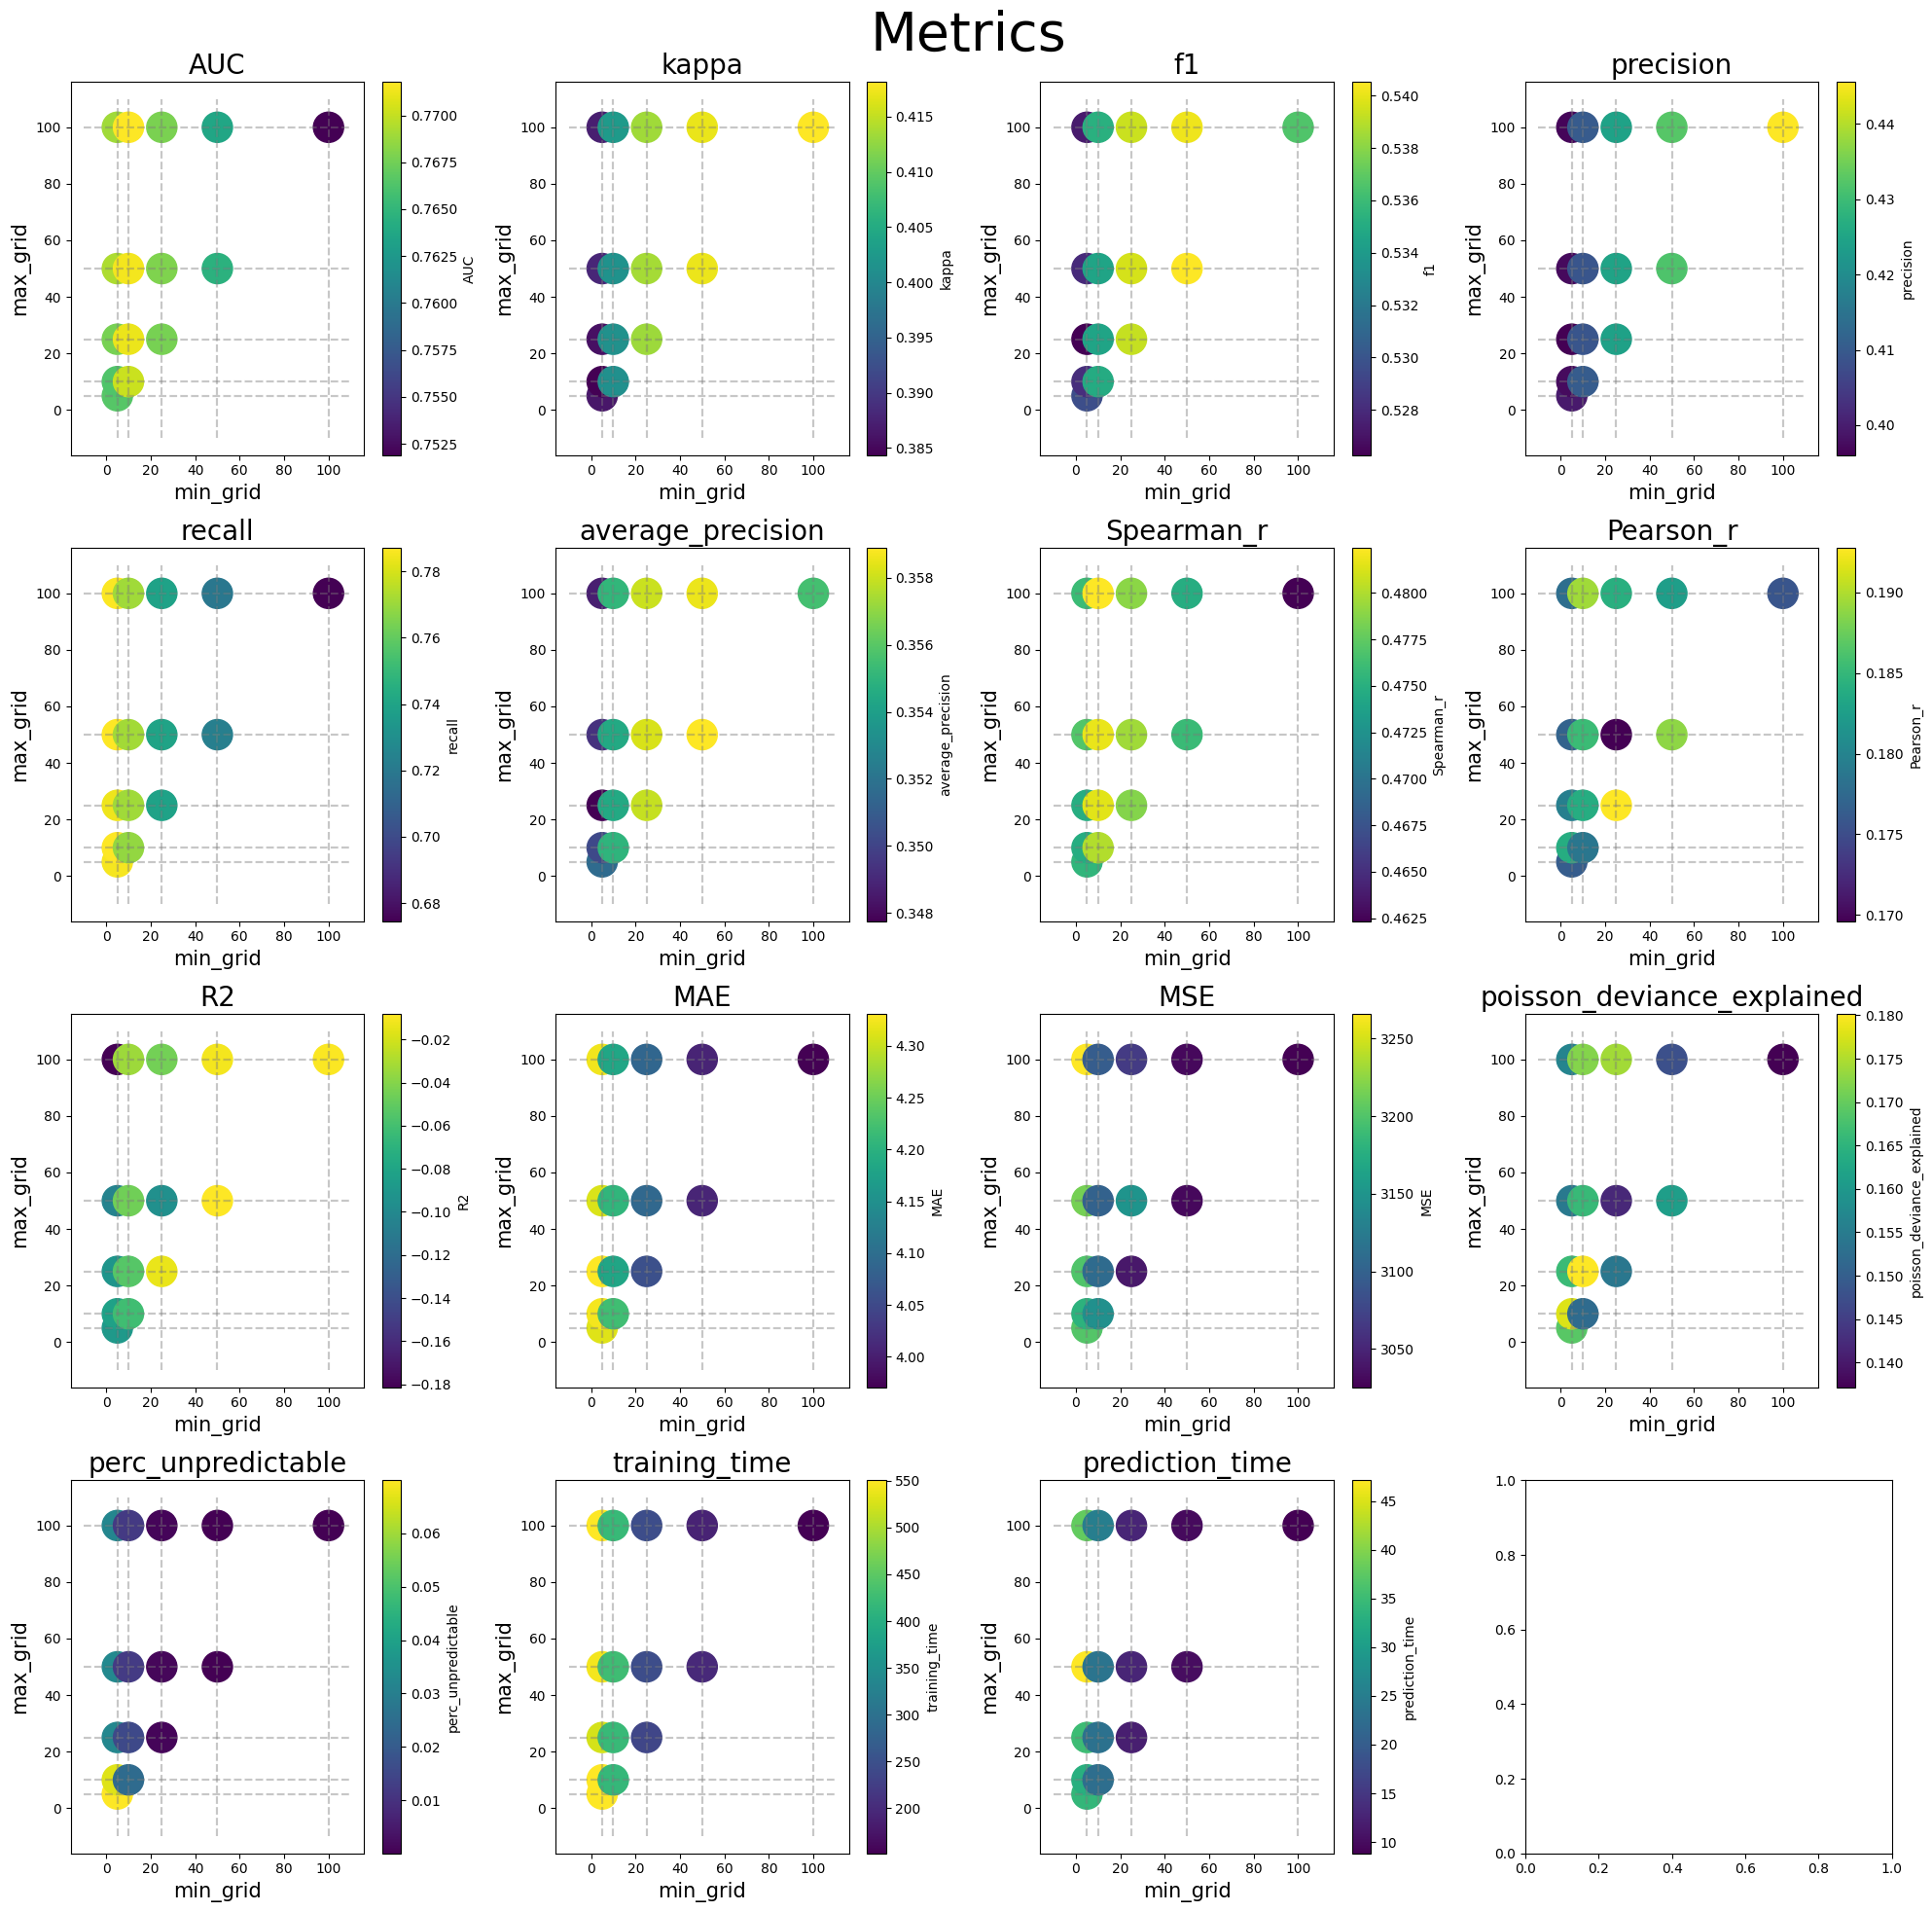

In [115]:
# plotting
vars_ = ['AUC', 'kappa', 'f1', 'precision',
       'recall', 'average_precision', 'Spearman_r', 'Pearson_r', 'R2', 'MAE',
       'MSE', 'poisson_deviance_explained', 'perc_unpredictable',
       'training_time', 'prediction_time']

column = 4
best_gridding = find_the_best_gridding(len(vars_), column=column)
fig, ax = plt.subplots(best_gridding, column, figsize=(20, 5*best_gridding))
plt.suptitle('Metrics',fontsize=40)

row = 0
col = 0

for metric in vars_:
    
    plt.sca(ax[row, col])
    for ii, xx in enumerate(set(list(min_grids) + list(max_grids))):
        for yy in list(set(list(min_grids) + list(max_grids))):
            plt.plot([xx, xx],[-10, 110], linestyle='--', c='tab:grey', alpha=0.1)
            plt.plot([-10, 110], [yy, yy],linestyle='--', c='tab:grey', alpha=0.1)
        
    p = plt.scatter(
        mean_metrics_df.min_grid,
        mean_metrics_df.max_grid,
        c=mean_metrics_df[metric],s=500
    )
        
    plt.colorbar(p, label=metric)
    plt.title(metric, fontsize=20)
    plt.xlabel('min_grid', fontsize=15)
    plt.ylabel('max_grid', fontsize=15)
    
    col += 1
    if col > column-1:
        col = 0
        row += 1
    

plt.tight_layout()
plt.show()




## Ranking the performance for tasks and efficiency

Besides plotting dots chart, we can average the metrics by target categories:

- Classification
- Regression
- Training efficiency
- Testing (prediction) efficiency

In [23]:
mean_metrics_df['min_max'] = mean_metrics_df.apply(lambda x:str(int(x['min_grid']))+'_'+str(int(x['max_grid'])), axis=1)


### Ranking for classification tasks

In [13]:
classification_metrics = ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision']
ranking_cls = mean_metrics_df[classification_metrics + ['min_max']].groupby('min_max').mean().rank(ascending=False)
ranking_cls['mean_ranking_cls'] = ranking_cls[['AUC','kappa','f1','average_precision']].mean(axis=1)
ranking_cls.sort_values(by='mean_ranking_cls')


,AUC,kappa,f1,precision,recall,average_precision,mean_ranking_cls
min_max,,,,,,,
25_50,7.0,4.0,3.0,4.0,10.0,3.0,4.25
50_50,13.0,2.0,1.0,3.0,13.0,1.0,4.25
25_100,8.0,5.0,4.0,5.0,11.0,4.0,5.25
50_100,14.0,3.0,2.0,2.0,14.0,2.0,5.25
10_100,1.0,7.0,7.0,8.0,8.0,7.0,5.50
25_25,10.0,6.0,5.0,6.0,12.0,5.0,6.50
100_100,15.0,1.0,6.0,1.0,15.0,6.0,7.00
10_50,2.0,8.0,9.0,10.0,6.0,10.0,7.25
10_10,4.0,10.0,8.0,7.0,9.0,8.0,7.50


### Ranking for regression tasks

In [14]:
regression_metrics1 = ['Spearman_r','Pearson_r','R2','poisson_deviance_explained']
regression_metrics2 = ['MAE','MSE']
ranking_reg1 = mean_metrics_df[regression_metrics1 + ['min_max']].groupby('min_max').mean().rank(ascending=False)
ranking_reg2 = mean_metrics_df[regression_metrics2 + ['min_max']].groupby('min_max').mean().rank(ascending=True)
ranking_reg = pd.concat([ranking_reg1, ranking_reg2], axis=1)
ranking_reg['mean_ranking_reg'] = ranking_reg.mean(axis=1)
ranking_reg.sort_values(by='mean_ranking_reg')


,Spearman_r,Pearson_r,R2,poisson_deviance_explained,MAE,MSE,mean_ranking_reg
min_max,,,,,,,
10_100,1.0,2.0,5.0,4.0,8.0,6.0,4.333333
50_50,10.0,3.0,1.0,8.0,3.0,3.0,4.666667
25_100,6.0,5.0,6.0,3.0,5.0,5.0,5.000000
25_25,7.0,1.0,4.0,11.0,4.0,4.0,5.166667
10_25,3.0,7.0,8.0,1.0,7.0,8.0,5.666667
10_50,2.0,4.0,7.0,7.0,9.0,7.0,6.000000
50_100,13.0,8.0,3.0,13.0,2.0,2.0,6.833333
100_100,15.0,14.0,2.0,15.0,1.0,1.0,8.000000
10_10,4.0,10.0,9.0,12.0,10.0,9.0,9.000000


### Ranking for time consumption

In [18]:
ranking_time = mean_metrics_df[['training_time','prediction_time'] + ['min_max']].groupby('min_max').mean().rank(ascending=True)
ranking_time.sort_values(by='prediction_time')


,training_time,prediction_time
min_max,,
100_100,1.0,1.0
50_100,2.0,2.0
50_50,3.0,3.0
25_25,4.0,4.0
25_50,6.0,5.0
25_100,5.0,6.0
10_10,7.0,7.0
10_25,8.0,8.0
10_50,10.0,9.0


### Finally, we plot these rankings using bump chart:

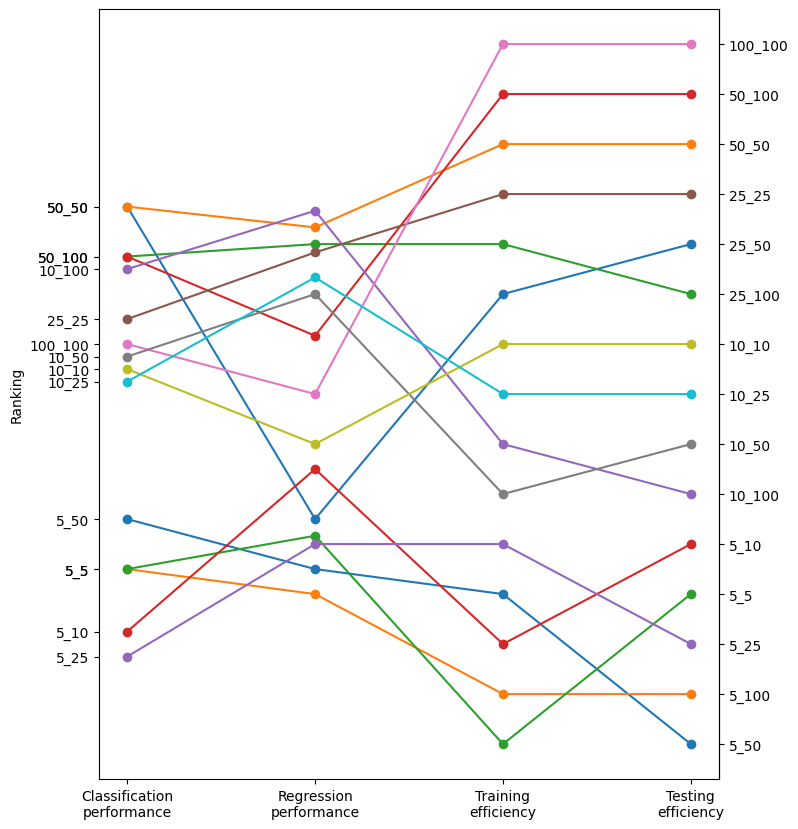

In [22]:
fig, ax = plt.subplots(figsize=(8, 10))
to_plot = pd.concat([ranking_cls, ranking_reg, ranking_time], axis=1).sort_values(by='mean_ranking_cls')
for index, line in to_plot.iterrows():
    ax.plot([1,2,3,4], [line['mean_ranking_cls'], line['mean_ranking_reg'], line['training_time'], line['prediction_time']], 'o-')

ax.set_yticks(to_plot['mean_ranking_cls'], list(to_plot.index))
yax2 = ax.secondary_yaxis("right")
yax2.set_yticks(to_plot['prediction_time'], list(to_plot.index))
ax.set_xticks([1,2,3,4], ['Classification\nperformance', 'Regression\nperformance', 'Training\nefficiency', 'Testing\nefficiency'])
ax.set_ylabel('Ranking')
ax.invert_yaxis()
plt.show()


## Conclusion

By reading the chart, `50_50` (minimum grid length as 50 unit and maximum set as 50) and `50_100` (minimum grid length as 50 unit and maximum set as 10) are the good balance between performance and efficiency in our case. They rank the top from both aspects.

Noteworthy, they are not the extreme cases, but are the median level gridding parameters. Sets like `5_5`, `5_20`, `5_25`, and `100_100` are worse than those median settings. They could be either overfitting or underfitting the data.

That says, the ranking seems significantly different – the absolute difference by digits is not that significant in our case, meaning that all these parameter sets may be acceptable.

The above situation and ranking may vary largely on a case-by-case bases, but generally I believe median level gridding will be the best balance between overfitting and underfitting.

From another perspective, you may want to use larger grid size for efficiency, because AdaSTEM has speed bottleneck at the prediction/testing step. Increasing the grid size will also equip you the capability of longer-distance prediction, for larger spatiotemporal regions are covered. Adjust the gird based on your need.

In [25]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,sklearn"))


Last updated: 2024-01-12T21:07:36.554533+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow  : 1.0.9.4
numpy     : 1.24.3
scipy     : 1.10.1
pandas    : 2.0.3
xgboost   : 1.7.6
tqdm      : 4.65.0
matplotlib: 3.7.1
h3pandas  : 0.2.4
geopandas : 0.11.1
sklearn   : 0.0

